In [1]:
%%writefile segmentation.py

import torch
import torch.nn as nn
import torch.nn.functional as F

from typing import Literal
import itertools
import torch


class WeightedCrossEntropyLoss(torch.nn.Module):
    # works for any kind of images
    def __init__(self, target: torch.Tensor | None = None, label_smoothing: float = 0.0):
        super().__init__()
        self._weight = None
        if target is not None:
            self.update_weight(target)
        self.label_smoothing = label_smoothing

    def update_weight(self, target: torch.Tensor) -> None:
        # expected target with clases expressed as integers
        class_counts = torch.bincount(target.flatten(), minlength=2)
        class_weights = 1.0 / (class_counts.float() + 1e-6)
        class_weights = class_weights / class_weights.sum()  # Normalize
        self._weight = class_weights

    def forward(self, x: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        Computes Cross Entropy Loss for multi-class segmentation.

        # Args
            - x: Tensor of predictions logits (type float) (batch_size, C, K1, K2 [, K3]).
            - target: Ground truth (type longint) (batch_size, 1, K1, K2 [, K3]).

        # Returns
            - Scalar (torch.Tensor).
        """
        target = target.squeeze(1) # torch.nn.functional.cross_entropy() does not want target with a channel dimension
        return torch.nn.functional.cross_entropy(
            x, target, 
            weight=self._weight.to(x.device) if self._weight is not None else None, 
            reduction='mean', 
            label_smoothing=self.label_smoothing
        )


class DiceLoss(torch.nn.Module):
    # (F1 / Sorensen-Dice)
    # from:
    # https://medium.com/data-scientists-diary/implementation-of-dice-loss-vision-pytorch-7eef1e438f68
    def __init__(
            self, 
            smooth: int=1, 
            class_reduction: Literal['none', 'mean', 'sum', 'foreground mean'] = 'mean', 
            batch_reduction: Literal['none', 'mean', 'sum'] = 'mean', 
            which: Literal['score', 'loss'] = 'loss'
        ):
        super().__init__()
        self.smooth = smooth
        self.class_reduction = class_reduction # applies class-wise
        self.batch_reduction = batch_reduction # applies batch element-wise # todo: to implement
        self.which = which

        # Runtime
        self.worst_indices = None # list[int]

        
    
    def __call__(self, x: torch.Tensor, target: torch.Tensor, x_is_probabilities: bool = False, save_worst_n_batch_indices: int = 0) -> torch.Tensor:
        """
        Computes Dice Loss for multi-class segmentation.

        # Args
            - x: Tensor of predictions logits (type float) (batch_size, C, K1, K2 [, K3]).
            - target: Ground truth (type longint) (batch_size, 1, K1, K2 [, K3]).
            - x_is_probabilities: (bool) wether x is probability in [0;1] instead of logits.

        # Returns
            - Scalar or vector Dice Loss (torch.Tensor).
        """
        if not x_is_probabilities:
            x = torch.nn.functional.softmax(x, dim=1)  # Convert logits to probabilities
        batch_size = x.shape[0]   # Number of samples (B)
        num_classes = x.shape[1]  # Number of classes (C)

        # Compute per-class, per-batch dice scores (higher better)
        dice = torch.zeros((batch_size, num_classes), device=x.device)
        for b, c in itertools.product(range(batch_size), range(num_classes)):
            pred_bc = x[b, c]
            target_bc = (target[b, 0] == c).float()
            intersection = (pred_bc * target_bc).sum()
            union = pred_bc.sum() + target_bc.sum()
            dice[b, c] = (2. * intersection + self.smooth) / (union + self.smooth)

        # If requested, return the worst samples
        worst_indices = None
        if (0 > save_worst_n_batch_indices) or (save_worst_n_batch_indices > batch_size):
            raise ValueError(print("Argument 'return_worst_n_batch_indices' must be in (0, batch_size)", True))
        if save_worst_n_batch_indices > 0:
            dice_avg_over_classes = dice.mean(dim=1).flatten()
            worst_indices = dice_avg_over_classes.argsort()
            worst_indices = worst_indices[0:save_worst_n_batch_indices]
            worst_indices = worst_indices.detach().cpu().numpy().tolist()
        self.worst_indices = worst_indices

        # Apply class reduction
        match self.class_reduction:
            case 'none':
                pass                     # nothing, -> (batch_size, num_classes)
            case 'mean':
                dice = dice.mean(dim=1)  # mean over classes, -> (batch_size,)
            case 'sum':
                dice = dice.sum(dim=1)   # sum over classes, -> (batch_size,)
            case 'foreground mean':
                # at leas one background (index 0) 
                # and one foreground (index 1 onward) 
                # are needed
                dice = dice[:, 1:].mean(dim=1)  # mean over foreground classes (all but first class dim), -> (batch_size,)
            case _:
                pass

        # Apply batch reduction
        match self.batch_reduction:
            case 'none':
                pass
            case 'mean':
                dice = dice.mean(dim=0)  # mean over batch
            case 'sum':
                dice = dice.sum(dim=0)   # sum over batch
            case _:
                pass
        
        match self.which:
            case 'score':
                pass
            case 'loss':
                dice = 1.0 - dice
            case _:
                pass
        
        return dice


class IoULoss(torch.nn.Module):
    # Jaccard
    # from:
    #
    def __init__(
            self, 
            smooth: int=1, 
            class_reduction: Literal['none', 'mean', 'sum', 'foreground mean'] = 'mean', 
            batch_reduction: Literal['none', 'mean', 'sum'] = 'mean', 
            which: Literal['score', 'loss'] = 'loss'
        ):
        super().__init__()
        self.smooth = smooth
        self.class_reduction = class_reduction # applies class-wise
        self.batch_reduction = batch_reduction # applies batch element-wise # todo: to implement
        self.which = which

        # Runtime
        self.worst_indices = None # list[int]

        
    
    def __call__(self, x: torch.Tensor, target: torch.Tensor, x_is_probabilities: bool = False, save_worst_n_batch_indices: int = 0) -> torch.Tensor:
        """
        Computes IoU Loss for multi-class segmentation.

        # Args
            - x: Tensor of predictions logits (type float) (batch_size, C, K1, K2 [, K3]).
            - target: Ground truth (type longint) (batch_size, 1, K1, K2 [, K3]).
            - x_is_probabilities: (bool) wether x is probability in [0;1] instead of logits.

        # Returns
            - Scalar or vector IoU Loss (torch.Tensor).
        """
        if not x_is_probabilities:
            x = torch.nn.functional.softmax(x, dim=1)  # Convert logits to probabilities
        batch_size = x.shape[0]   # Number of samples (B)
        num_classes = x.shape[1]  # Number of classes (C)

        # Compute per-class, per-batch IoU scores (higher better)
        iou = torch.zeros((batch_size, num_classes), device=x.device)
        for b, c in itertools.product(range(batch_size), range(num_classes)):
            pred_bc = x[b, c]
            target_bc = (target[b, 0] == c).float()
            intersection = (pred_bc * target_bc).sum()
            union = pred_bc.sum() + target_bc.sum() - intersection
            iou[b, c] = (intersection + self.smooth) / (union + self.smooth)

        # If requested, return the worst samples
        worst_indices = None
        if (0 > save_worst_n_batch_indices) or (save_worst_n_batch_indices > batch_size):
            raise ValueError(print("Argument 'return_worst_n_batch_indices' must be in (0, batch_size)", True))
        if save_worst_n_batch_indices > 0:
            iou_avg_over_classes = iou.mean(dim=1).flatten()
            worst_indices = iou_avg_over_classes.argsort()
            worst_indices = worst_indices[0:save_worst_n_batch_indices]
            worst_indices = worst_indices.detach().cpu().numpy().tolist()
        self.worst_indices = worst_indices

        # Apply class reduction
        match self.class_reduction:
            case 'none':
                pass                     # nothing, -> (batch_size, num_classes)
            case 'mean':
                iou = iou.mean(dim=1)  # mean over classes, -> (batch_size,)
            case 'sum':
                iou = iou.sum(dim=1)   # sum over classes, -> (batch_size,)
            case 'foreground mean':
                # at leas one background (index 0) 
                # and one foreground (index 1 onward) 
                # are needed
                iou = iou[:, 1:].mean(dim=1)  # mean over foreground classes (all but first class dim), -> (batch_size,)
            case _:
                pass

        # Apply batch reduction
        match self.batch_reduction:
            case 'none':
                pass
            case 'mean':
                iou = iou.mean(dim=0)  # mean over batch
            case 'sum':
                iou = iou.sum(dim=0)   # sum over batch
            case _:
                pass
        
        match self.which:
            case 'score':
                pass
            case 'loss':
                iou = 1.0 - iou
            case _:
                pass
        
        return iou
 

Writing segmentation.py


In [2]:
# ============================
# FULL RAM + GPU CLEANUP
# ============================

import gc, torch, matplotlib.pyplot as plt

print("Chiudo tutte le figure...")
plt.close('all')

# Cancello oggetti comuni del training
for name in [
    "model", "train_ds", "val_ds",
    "img_batch", "lab_batch", "pred",
    "img_b", "lab_b",
    "img_full_c", "lab_full_c",
    "pred_bin_c", "pred_prob_c",
]:
    if name in globals():
        del globals()[name]

# Cancello TUTTE le variabili grandi automaticamente
big_vars = []
for k, v in list(globals().items()):
    try:
        # tensore, numpy array o lista enorme
        if hasattr(v, "shape") or (isinstance(v, list) and len(v) > 200):
            big_vars.append(k)
            del globals()[k]
    except:
        pass

print("Variabili grandi cancellate:", big_vars)

# Garbage collector CPU
print("GC collect...")
gc.collect()

# Svuoto cache GPU
if torch.cuda.is_available():
    print("Svuoto VRAM...")
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

print("Cleanup completato.")


import torch, gc

gc.collect()
torch.cuda.empty_cache()
print("CUDA cache svuotata.")

torch.cuda.empty_cache()




Chiudo tutte le figure...
Variabili grandi cancellate: []
GC collect...
Svuoto VRAM...
Cleanup completato.
CUDA cache svuotata.


# Applied AI in Biomedicine - All-in-One Notebook

This notebook contains the entire pipeline (Models, Dataset, Training, Inference) in one place.
**Instructions:**
1. Upload your `training_images` folder and `training_metadata.xlsx` to Google Drive (e.g., in `MyDrive/Assignment_Data`).
2. Mount Drive below.
3. Update `DATA_DIR` and `EXCEL_PATH` in the Configuration cell.
4. Run all cells.

In [3]:
# ============================================================
# IMPORT PULITI
# ============================================================

import os
import random
from pathlib import Path
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from torchvision import models, transforms
import torchvision.transforms as T

import torchvision.transforms.functional as TF

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
)

from tqdm import tqdm

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in uso:", device)


PyTorch version: 2.6.0+cu124
CUDA available: True
Device in uso: cuda


In [4]:
# ============================================================
# CELL 2 - CONFIG GENERALE (QUI METTI I TUOI PATH)
# ============================================================

DATA_DIR = "/kaggle/input/tumor-segmentation-ai/training_images/training_images" #Tuttavia, devo assicurarmi che questo cambiamento corrisponda anche alle logiche per caricare i dati di classificazione cartella con le immagini .png
EXCEL_PATH = "/kaggle/input/tumor-segmentation-ai/training_metadata.xlsx"   # file con colonna 'US' e 'LABEL'
OUTPUT_DIR = "/kaggle/working/"                          # dove salvare pesi e metadata


# 🔴 QUI: metti lo STESSO path al file Excel che usavi nel notebook originale
EXCEL_PATH = "/kaggle/input/tumor-segmentation-ai/training_metadata.xlsx"


# mapping label → nome classe (come nel tuo progetto)
id2class = {
    0: "benigno",
    1: "maligno",
    2: "sano",
}
class2id = {v: k for k, v in id2class.items()}

print("Config OK")


Config OK


## 2. Dataset Class

In [5]:
class UltrasoundDataset(Dataset):
    def __init__(self, metadata_df, images_dir, mode='segmentation', transform=None):
        """
        mode: 'segmentation' oppure 'classification'
        """
        self.metadata = metadata_df.reset_index(drop=True)
        self.images_dir = images_dir
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        img_name = row['US']
        mask_name = row.get('MASK', None)
        label = row.get('LABEL', None)

        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.mode == 'segmentation':
            if mask_name is None:
                raise ValueError("MASK mancante per modalità 'segmentation'")
            mask_path = os.path.join(self.images_dir, mask_name)
            mask = Image.open(mask_path).convert("L")
            # qui image e mask restano PIL, le trasformazioni le fa il wrapper
            return image, mask

        elif self.mode == 'classification':
            if self.transform:
                image = self.transform(image)
            return image, int(label)

        else:
            raise ValueError(f"mode sconosciuto: {self.mode}")


def get_dataloaders(
    data_dir,
    excel_path,
    batch_size=16,
    mode='segmentation',
    img_size=256,
    norm_stats=None,
):
    """
    mode: 'segmentation' o 'classification'
    norm_stats: (mean, std), es:
        - ImageNet: ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        - generico: ([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    """

    if not os.path.exists(data_dir) or not os.path.exists(excel_path):
        raise FileNotFoundError(f"Data not found at {data_dir} or {excel_path}")

    # default: ImageNet
    if norm_stats is None:
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    else:
        mean, std = norm_stats

    df = pd.read_excel(excel_path)
    train_df, test_val_df = train_test_split(
        df,
        test_size=0.3,
        stratify=df['LABEL'],
        random_state=42,
    )
    val_df, test_df = train_test_split(
        test_val_df,
        test_size=0.5,
        stratify=test_val_df['LABEL'],
        random_state=42,
    )

    # ============================
    #  TRANSFORM COMUNI
    # ============================
    normalize_tf = T.Normalize(mean=mean, std=std)

    # ---------- joint transforms per segmentation ----------
    class JointCompose:
        def __init__(self, transforms):
            self.transforms = transforms

        def __call__(self, img, mask):
            for t in self.transforms:
                img, mask = t(img, mask)
            return img, mask

    class JointResize:
        def __init__(self, size):
            self.size = size

        def __call__(self, img, mask):
            return (
                TF.resize(img, self.size),
                TF.resize(mask, self.size, interpolation=T.InterpolationMode.NEAREST),
            )

    class JointToTensor:
        def __call__(self, img, mask):
            return TF.to_tensor(img), TF.to_tensor(mask)

    class JointRandomHorizontalFlip:
        def __init__(self, p=0.5):
            self.p = p

        def __call__(self, img, mask):
            if random.random() < self.p:
                return TF.hflip(img), TF.hflip(mask)
            return img, mask

    class JointRandomVerticalFlip:
        def __init__(self, p=0.5):
            self.p = p

        def __call__(self, img, mask):
            if random.random() < self.p:
                return TF.vflip(img), TF.vflip(mask)
            return img, mask

    class JointRandomRotation:
        def __init__(self, degrees=10):
            self.degrees = degrees

        def __call__(self, img, mask):
            angle = random.uniform(-self.degrees, self.degrees)
            img = TF.rotate(img, angle)
            mask = TF.rotate(mask, angle, interpolation=T.InterpolationMode.NEAREST)
            return img, mask

    class JointImageColorJitter:
        """jitter solo sull'immagine (ecografia), non sulla mask."""
        def __init__(self, brightness=0.1, contrast=0.1):
            self.jitter = T.ColorJitter(brightness=brightness, contrast=contrast)

        def __call__(self, img, mask):
            img = self.jitter(img)
            return img, mask

    class JointNormalize:
        def __init__(self, mean, std):
            self.norm = T.Normalize(mean=mean, std=std)

        def __call__(self, img, mask):
            return self.norm(img), mask

    # wrapper per applicare joint transforms al dataset base
    class SegmentationWrapper(Dataset):
        def __init__(self, base_dataset, transform):
            self.base = base_dataset
            self.transform = transform

        def __len__(self):
            return len(self.base)

        def __getitem__(self, idx):
            img, mask = self.base[idx]  # PIL
            img, mask = self.transform(img, mask)
            return img, mask

    # ============================
    #  SEGMENTATION
    # ============================
    if mode == 'segmentation':
        train_base = UltrasoundDataset(train_df, data_dir, mode='segmentation')
        val_base = UltrasoundDataset(val_df, data_dir, mode='segmentation')
        test_base = UltrasoundDataset(test_df, data_dir, mode='segmentation')

        train_transform = JointCompose([
            JointResize((img_size, img_size)),
            JointRandomHorizontalFlip(p=0.5),
            JointRandomVerticalFlip(p=0.5),
            JointRandomRotation(degrees=10),
            JointImageColorJitter(brightness=0.1, contrast=0.1),
            JointToTensor(),
            JointNormalize(mean, std),
        ])

        val_transform = JointCompose([
            JointResize((img_size, img_size)),
            JointToTensor(),
            JointNormalize(mean, std),
        ])

        train_ds = SegmentationWrapper(train_base, train_transform)
        val_ds = SegmentationWrapper(val_base, val_transform)
        test_ds = SegmentationWrapper(test_base, val_transform)

        # per segmentation non serve sampler sulle LABEL
        train_loader = DataLoader(
            train_ds,
            batch_size=batch_size,
            shuffle=True,
            num_workers=4,
        )

        val_loader = DataLoader(
            val_ds,
            batch_size=batch_size,
            shuffle=False,
            num_workers=4,
        )

        test_loader = DataLoader(
            test_ds,
            batch_size=batch_size,
            shuffle=False,
            num_workers=4,
        )

        return train_loader, val_loader, test_loader

    # ============================
    #  CLASSIFICATION
    # ============================
    # augmentation + normalizzazione
    train_transform = T.Compose([
        T.Resize((img_size, img_size)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(degrees=15),
        T.RandomResizedCrop(img_size, scale=(0.9, 1.0)),
        T.ToTensor(),
        normalize_tf,
    ])

    val_transform = T.Compose([
        T.Resize((img_size, img_size)),
        T.ToTensor(),
        normalize_tf,
    ])

    train_ds = UltrasoundDataset(
        train_df, data_dir, mode='classification', transform=train_transform
    )
    val_ds = UltrasoundDataset(
        val_df, data_dir, mode='classification', transform=val_transform
    )
    test_ds = UltrasoundDataset(
        test_df, data_dir, mode='classification', transform=val_transform
    )

    # ---------- bilanciamento 3 classi sul train ----------
    labels = train_df['LABEL'].values
    classes, counts = np.unique(labels, return_counts=True)
    class_weights = {cls: 1.0 / c for cls, c in zip(classes, counts)}
    sample_weights = np.array([class_weights[l] for l in labels], dtype=np.float32)

    sampler = WeightedRandomSampler(
        weights=torch.from_numpy(sample_weights),
        num_samples=len(sample_weights),
        replacement=True,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        sampler=sampler,  # bilanciato
        num_workers=4,
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
    )
    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
    )

    return train_loader, val_loader, test_loader

# CLASSIFICATION

In [6]:
## PARAMETERS FIXING
IMG_SIZE = 256
BATCH_SIZE = 32
NUM_WORKERS = 2   
NUM_EPOCHS = 100
LR = 1e-3
EARLY_STOPPING_PATIENCE = 15

In [7]:
# ============================================================
# 1) DATALOADER PER CLASSIFICATION (3 classi: 0 / 1 / 2)
# ============================================================

train_loader, val_loader, test_loader = get_dataloaders(
    data_dir=DATA_DIR,
    excel_path=EXCEL_PATH,
    batch_size=BATCH_SIZE,
    mode="classification",   # oppure "segmentation"
    img_size=IMG_SIZE
)

print("Train batches:", len(train_loader))
print("Val batches  :", len(val_loader))
print("Test batches :", len(test_loader))

# ricavo num_classes dal contenuto vero del loader
all_labels_tmp = []

for _, labels in train_loader:
    all_labels_tmp.append(labels.numpy())

all_labels_tmp = np.concatenate(all_labels_tmp)
num_classes = len(np.unique(all_labels_tmp))

print("num_classes:", num_classes)

# se non hai ancora device / LR / ecc, li definisci qui
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device classification:", device)




Train batches: 33
Val batches  : 8
Test batches : 8
num_classes: 3
Device classification: cuda


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 243MB/s]


Ultima parte del modello:
Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=256, out_features=3, bias=True)
)

Parametri totali: 24033347
Parametri allenabili: 7623683
Loss, optimizer (2 gruppi LR) e scheduler definiti.

===== EPOCH 1/5 =====
   Batch 0/33 - loss batch: 1.1125
   Batch 20/33 - loss batch: 0.9302
[TRAIN] loss=0.9431 | acc=0.5323 | bal_acc=0.5329 | f1=0.5337
   Batch 0/8 - loss batch: 0.8518
[VAL]   loss=0.9861 | acc=0.5289 | bal_acc=0.5431 | f1=0.4945
>> Nuovo best model (val_bal_acc migliorata a 0.5431).

===== EPOCH 2/5 =====
   Batch 0/33 - loss batch: 0.7520
   Batch 20/33 - loss batch: 0.7633
[TRAIN] loss=0.7377 | acc=0.6759 | bal_acc=0.6805 | f1=0.6771
   Batch 0/8 - loss batch: 0.6456
[VAL]   loss=0.8929 | acc=0.6044 | bal_acc=0.6174 | f1=0.5918
>> Nuovo best model (val_bal_acc migliorata a 0.6174).

===== EPOCH 3/5 =====
   Batch 0/33 - loss batch: 0.6403
   Batch

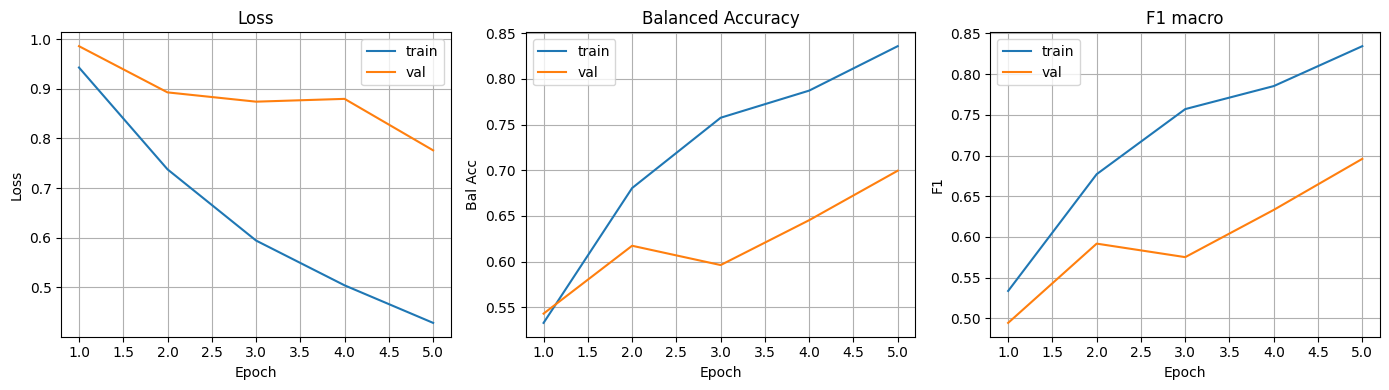

In [8]:


# ============================================================
# 2) MODELLO RESNET50 (sblocco ultimi layer) – BEST_FIL
# ============================================================

n_classes = num_classes  

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# 1) Freezo tutto
for param in model.parameters():
    param.requires_grad = False

# 2) Sostituisco la testa
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, n_classes),
)

# 3) Sblocco layer3 (ultimo blocco residuo) + fc
backbone_params = []
head_params = []
for name, param in model.named_parameters():
    if name.startswith("layer3"):
        param.requires_grad = True
        backbone_params.append(param)
    elif name.startswith("fc"):
        param.requires_grad = True
        head_params.append(param)

model = model.to(device)

print("Ultima parte del modello:")
print(model.fc)

# conteggio parametri
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"\nParametri totali: {total_params}")
print(f"Parametri allenabili: {trainable_params}")

# ============================================================
# 3) LOSS, OPTIMIZER (2 gruppi LR) E SCHEDULER
# ============================================================

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    [
        {"params": backbone_params, "lr": LR * 0.1},  # layer3 più lento
        {"params": head_params,     "lr": LR},        # testa normale
    ],
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=3,
)

print("Loss, optimizer (2 gruppi LR) e scheduler definiti.")

# ============================================================
# 4) UNA EPOCA (TRAIN O VAL)
# ============================================================

def run_one_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    if is_train:
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    all_labels = []
    all_preds = []

    for batch_idx, (images, labels) in enumerate(loader):
        images = images.to(device)
        labels = labels.to(device)

        if is_train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(is_train):
            outputs = model(images)
            loss = criterion(outputs, labels)

            if is_train:
                loss.backward()
                optimizer.step()

        running_loss += loss.item() * images.size(0)

        preds = torch.argmax(outputs, dim=1)
        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

        if batch_idx % 20 == 0:
            print(f"   Batch {batch_idx}/{len(loader)} - loss batch: {loss.item():.4f}")

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_bal_acc = balanced_accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average="macro")

    return epoch_loss, epoch_acc, epoch_bal_acc, epoch_f1

# ============================================================
# 5) TRAIN COMPLETO CON EARLY STOP (su balanced accuracy)
# ============================================================


best_val_bal_acc = 0.0  # miglior balanced accuracy in validazione
best_model_wts = copy.deepcopy(model.state_dict())
epochs_no_improve = 0

history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
    "train_bal_acc": [],
    "val_bal_acc": [],
    "train_f1": [],
    "val_f1": [],
}

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n===== EPOCH {epoch}/{NUM_EPOCHS} =====")

    train_loss, train_acc, train_bal_acc, train_f1 = run_one_epoch(
        model, train_loader, optimizer=optimizer
    )
    print(f"[TRAIN] loss={train_loss:.4f} | acc={train_acc:.4f} | bal_acc={train_bal_acc:.4f} | f1={train_f1:.4f}")

    val_loss, val_acc, val_bal_acc, val_f1 = run_one_epoch(
        model, val_loader, optimizer=None
    )
    print(f"[VAL]   loss={val_loss:.4f} | acc={val_acc:.4f} | bal_acc={val_bal_acc:.4f} | f1={val_f1:.4f}")

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["train_bal_acc"].append(train_bal_acc)
    history["val_bal_acc"].append(val_bal_acc)
    history["train_f1"].append(train_f1)
    history["val_f1"].append(val_f1)

    # scheduler ancora basato su val_loss
    scheduler.step(val_loss)

    # EARLY STOPPING su balanced accuracy
    if val_bal_acc > best_val_bal_acc:
        best_val_bal_acc = val_bal_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
        print(f">> Nuovo best model (val_bal_acc migliorata a {best_val_bal_acc:.4f}).")
    else:
        epochs_no_improve += 1
        print(f">> Nessun miglioramento bal_acc. epochs_no_improve = {epochs_no_improve}")

    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print("\nEARLY STOPPING attivato (su balanced accuracy).")
        break

print("\nTraining finito.")
model.load_state_dict(best_model_wts)
print(f"Caricati i pesi migliori (miglior val_bal_acc = {best_val_bal_acc:.4f}).")

# ============================================================
# 6) PLOT CURVE TRAIN/VAL
# ============================================================

epochs_range = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.plot(epochs_range, history["train_loss"], label="train")
plt.plot(epochs_range, history["val_loss"], label="val")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1,3,2)
plt.plot(epochs_range, history["train_bal_acc"], label="train")
plt.plot(epochs_range, history["val_bal_acc"], label="val")
plt.title("Balanced Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Bal Acc")
plt.legend()
plt.grid(True)

plt.subplot(1,3,3)
plt.plot(epochs_range, history["train_f1"], label="train")
plt.plot(epochs_range, history["val_f1"], label="val")
plt.title("F1 macro")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


=== RISULTATI TEST ===
Accuracy        : 0.7301
Balanced Acc    : 0.7194
F1 macro        : 0.7198

Classification report:
              precision    recall  f1-score   support

     benigno       0.74      0.80      0.77       102
     maligno       0.62      0.75      0.68        55
        sano       0.86      0.61      0.71        69

    accuracy                           0.73       226
   macro avg       0.74      0.72      0.72       226
weighted avg       0.75      0.73      0.73       226

Confusion matrix (raw counts):
[[82 15  5]
 [12 41  2]
 [17 10 42]]


<Figure size 500x400 with 0 Axes>

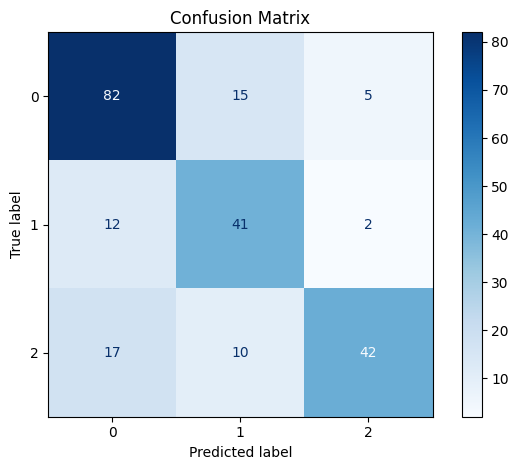

In [9]:

# ============================================================
# 7) VALUTAZIONE SU TEST
# ============================================================

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)

test_acc = accuracy_score(all_labels, all_preds)
test_bal_acc = balanced_accuracy_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds, average="macro")

print("=== RISULTATI TEST ===")
print(f"Accuracy        : {test_acc:.4f}")
print(f"Balanced Acc    : {test_bal_acc:.4f}")
print(f"F1 macro        : {test_f1:.4f}\n")

if "id2class" in globals():
    target_names = [id2class[i] for i in sorted(set(all_labels))]
    print("Classification report:")
    print(classification_report(all_labels, all_preds, target_names=target_names))
else:
    print("Classification report:")
    print(classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
print("Confusion matrix (raw counts):")
print(cm)

plt.figure(figsize=(5,4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()



In [10]:
def compute_predictions_for_all(model, excel_path, data_dir, img_size=256):
    df = pd.read_excel(excel_path)

    # Trasformazioni come nella classification
    transform = T.Compose([
        T.Resize((img_size, img_size)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    preds = []
    model.eval()

    with torch.no_grad():
        for idx, row in tqdm(df.iterrows(), total=len(df)):
            img_path = os.path.join(data_dir, row["US"])
            img = Image.open(img_path).convert("RGB")
            img = transform(img).unsqueeze(0).to(device)

            out = model(img)
            pred = out.argmax(dim=1).item()

            preds.append(pred)

    df["PRED_LABEL"] = preds
    return df

pred_df = compute_predictions_for_all(
    model=model,
    excel_path=EXCEL_PATH,
    data_dir=DATA_DIR,
    img_size=256
)

pred_df.head()

100%|██████████| 1503/1503 [00:33<00:00, 45.05it/s]


,US,MASK,LABEL,PRED_LABEL
0,1.png,1_mask.png,2,1
1,2.png,2_mask.png,2,2
2,3.png,3_mask.png,2,1
3,4.png,4_mask.png,2,1
4,5.png,5_mask.png,2,0


In [11]:
# ============================================================
# 8) PREDIZIONI SU TUTTO L'EXCEL PER CREARE SEGMENTATION METADATA
# ============================================================


# usiamo la PRED_LABEL come LABEL per costruire il dataset di segmentazione
pred_df["LABEL"] = pred_df["PRED_LABEL"]
seg_df = pred_df[pred_df["LABEL"] != 2].reset_index(drop=True)  # escludi classe "sana" = 2
print("Dataset di segmentazione:", len(seg_df))

seg_metadata_path = os.path.join(OUTPUT_DIR, "segmentation_metadata_based_on_preds.xlsx")
seg_df.to_excel(seg_metadata_path, index=False)
print("Salvato:", seg_metadata_path)

Dataset di segmentazione: 1197
Salvato: /kaggle/working/segmentation_metadata_based_on_preds.xlsx


EFFICIENTNETV2_L (ONLY LAST 2 BACKBONE LAYERS + HEAD LAYER; DIFFERENT LR FOR HEAD AND BACKBONE)

=== TEST RESULTS ===
Test loss        : 0.3957
Test accuracy    : 0.8584
Test bal_accuracy: 0.8457



# SEGMENTATION

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Device SMP U-Net: cuda
Train batches (seg): 27
Val   batches (seg): 6
Test  batches (seg): 6


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 415MB/s]


cuda:0
Estimated pos_weight for BCE: 11.931421570168997


Epoch 1/5 [val]: 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]



Epoch 001/5 | train_loss=0.7756, train_dice=0.2046 | val_loss=0.8708, val_dice=0.1799, val_iou=0.1104
🔥 New best Dice on val: 0.1799


Epoch 2/5 [val]: 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]



Epoch 002/5 | train_loss=0.6522, train_dice=0.2842 | val_loss=0.9416, val_dice=0.1202, val_iou=0.0681


Epoch 3/5 [val]: 100%|██████████| 6/6 [00:01<00:00,  3.23it/s]



Epoch 003/5 | train_loss=0.5938, train_dice=0.3378 | val_loss=0.9495, val_dice=0.1178, val_iou=0.0664


Epoch 4/5 [val]: 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]



Epoch 004/5 | train_loss=0.5421, train_dice=0.3892 | val_loss=0.9419, val_dice=0.1218, val_iou=0.0691


Epoch 5/5 [val]: 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]



Epoch 005/5 | train_loss=0.4963, train_dice=0.4378 | val_loss=0.9758, val_dice=0.1079, val_iou=0.0603

Loaded best model (val Dice=0.1799)


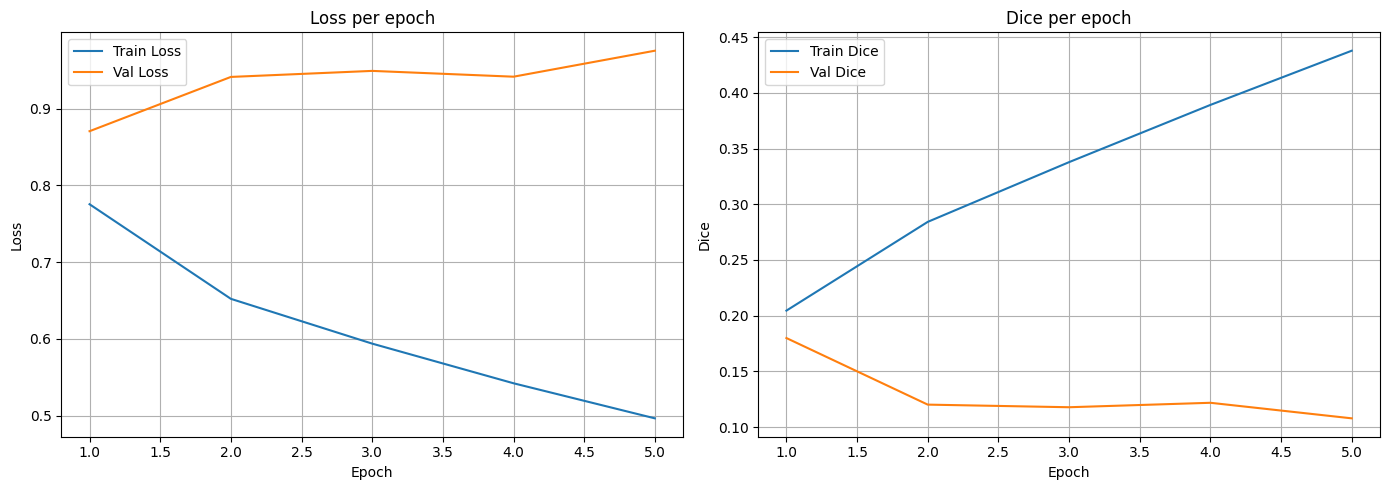

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


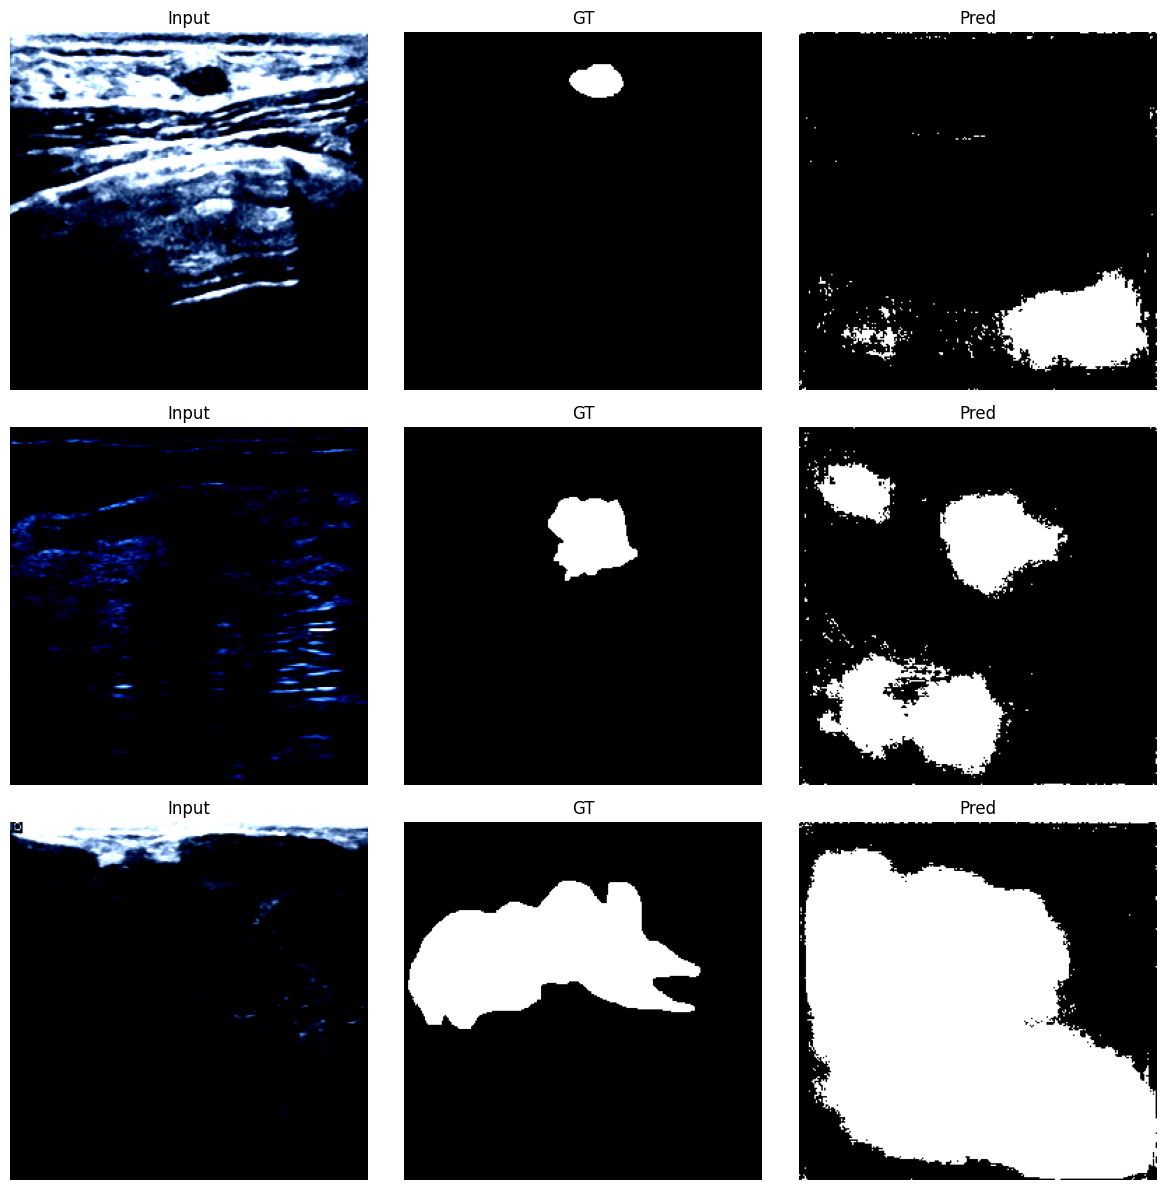

Test seg: 100%|██████████| 6/6 [00:01<00:00,  3.05it/s]

Test Dice: 0.3016
Test IoU : 0.2073


Esempi salvati in: /kaggle/working/seg_examples_smp_unet


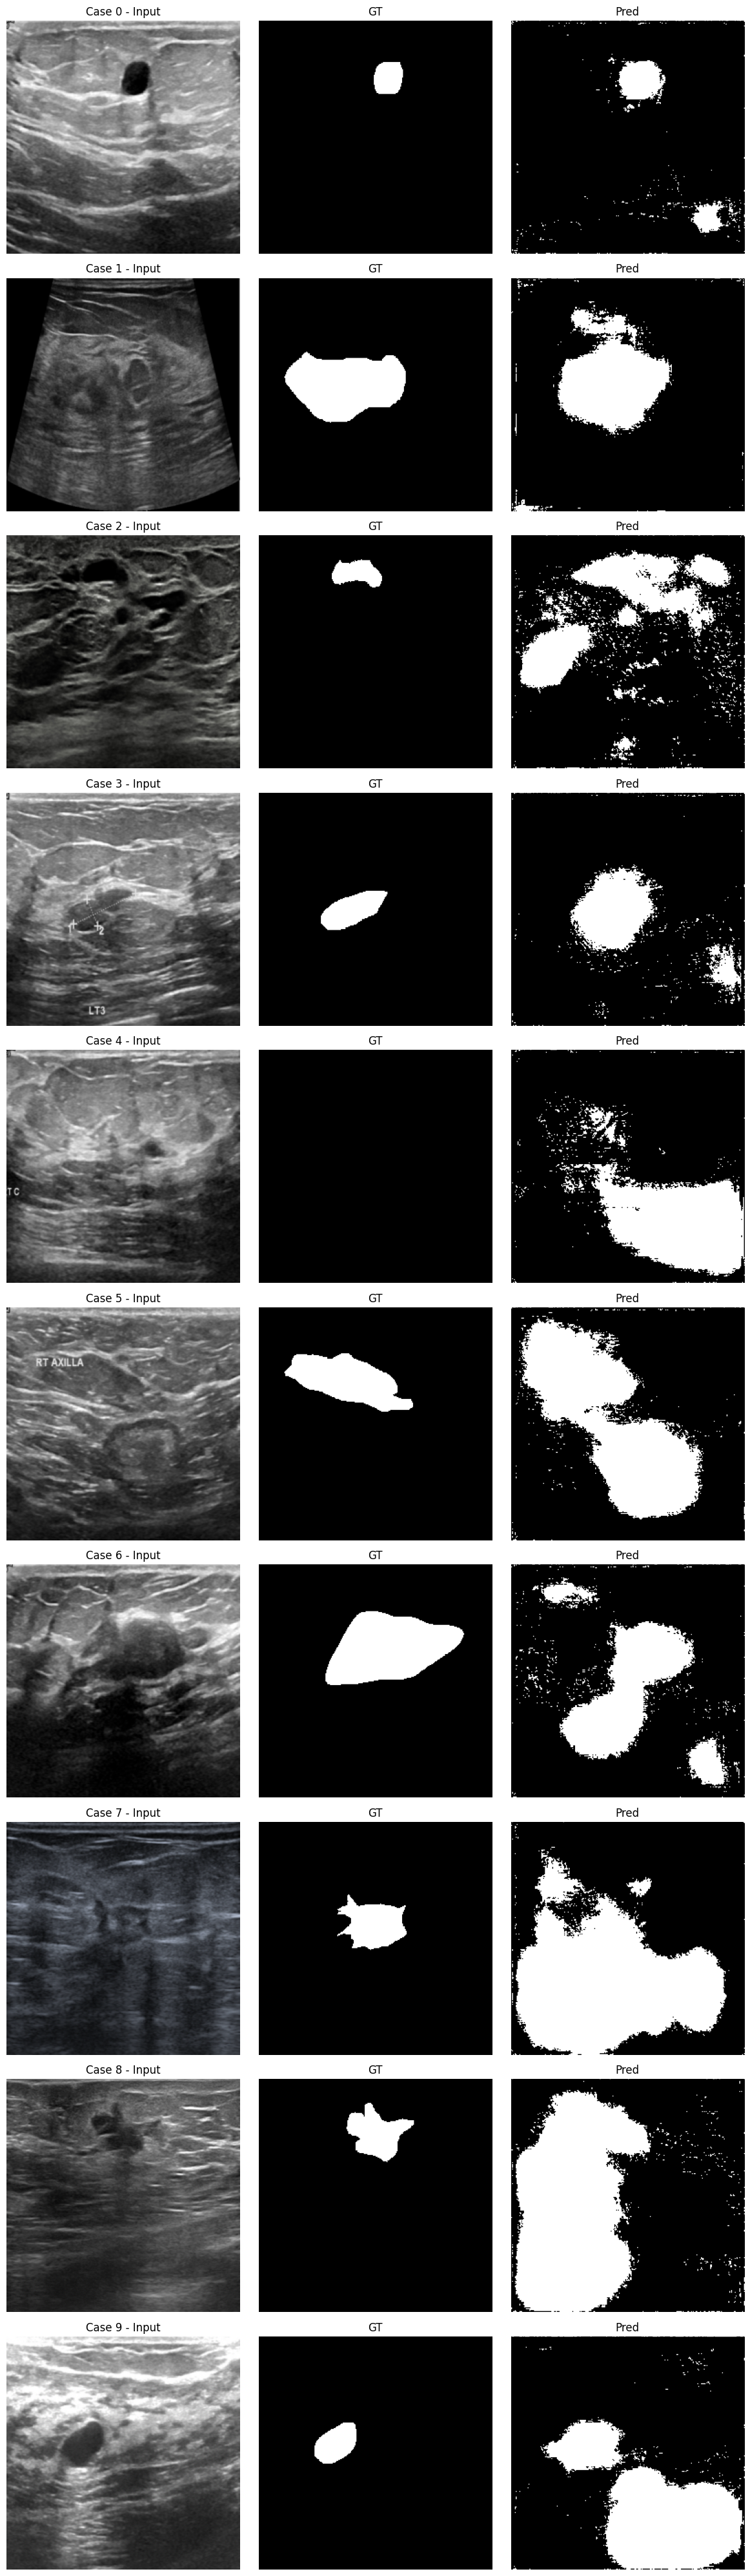

Immagini test con tumore: 158
Dice (solo tumore): 0.3436
IoU  (solo tumore): 0.2362
Loss (solo tumore): 0.8436


'unet_graph.png'

In [12]:
# ============================================================
# SEGMENTATION DATAFRAME -> EXCEL
# ============================================================
seg_df.to_excel(os.path.join(OUTPUT_DIR, "temp_segmentation_metadata.xlsx"), index=False)

train_loader_seg, val_loader_seg, test_loader_seg = get_dataloaders(
    data_dir=DATA_DIR,
    excel_path=os.path.join(OUTPUT_DIR, "temp_segmentation_metadata.xlsx"),
    batch_size=BATCH_SIZE,
    mode="segmentation",
    img_size=IMG_SIZE
)

# ============================================================
#   U-NET (smp) + BBOX CHANNEL – FULL TRAINING
# ============================================================

!pip install segmentation-models-pytorch==0.3.3 --quiet
!pip install albumentations==1.3.0 --quiet

import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import segmentation_models_pytorch as smp

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device SMP U-Net:", device)

# ------------------------------------------------------------
# 1) Dataloaders segmentation (riuso get_dataloaders)
# ------------------------------------------------------------

# normalizzazione default (ImageNet)
norm_stats = None

# parametri dataset
BATCH_SIZE = 16
IMG_SIZE   = 320   # o 320 se vuoi provare più grande

print("Train batches (seg):", len(train_loader_seg))
print("Val   batches (seg):", len(val_loader_seg))
print("Test  batches (seg):", len(test_loader_seg))

# ------------------------------------------------------------
# 2) Helper: bbox channel
# ------------------------------------------------------------

def make_bbox_channel(masks: torch.Tensor) -> torch.Tensor:
    """
    masks: [B,1,H,W] (0/1)
    ritorna bbox_ch: [B,1,H,W] con 1 dentro il bounding box del tumore.
    """
    B, _, H, W = masks.shape
    bbox_ch = torch.zeros(B, 1, H, W, device=masks.device, dtype=masks.dtype)

    for b in range(B):
        m = (masks[b, 0] > 0.5)
        ys, xs = torch.where(m)
        if ys.numel() == 0:
            continue
        y_min, y_max = ys.min(), ys.max()
        x_min, x_max = xs.min(), xs.max()
        bbox_ch[b, 0, y_min:y_max+1, x_min:x_max+1] = 1.0

    return bbox_ch


def add_bbox_to_images(
    imgs: torch.Tensor,
    masks: torch.Tensor = None,
    use_gt_bbox: bool = True
) -> torch.Tensor:
    """
    imgs:  [B,3,H,W]
    masks: [B,1,H,W] (opzionale)
    use_gt_bbox = True  -> usa GT per generare la bbox (train)
    use_gt_bbox = False -> canale bbox tutto a zero (val/test, niente leakage)
    """
    B, _, H, W = imgs.shape
    if use_gt_bbox and (masks is not None):
        bbox_ch = make_bbox_channel(masks)
    else:
        bbox_ch = torch.zeros(B, 1, H, W, device=imgs.device, dtype=imgs.dtype)

    return torch.cat([imgs, bbox_ch], dim=1)

# ------------------------------------------------------------
# 3) SMP U-Net (ResNet50) con 4 canali in input
# ------------------------------------------------------------

unet = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,   # temporaneo
    classes=1,
)

old_conv = unet.encoder.conv1  # per resnet50

new_conv = nn.Conv2d(
    4,
    old_conv.out_channels,
    kernel_size=old_conv.kernel_size,
    stride=old_conv.stride,
    padding=old_conv.padding,
    bias=old_conv.bias is not None,
)

with torch.no_grad():
    new_conv.weight[:, :3, :, :] = old_conv.weight
    new_conv.weight[:, 3:4, :, :] = old_conv.weight.mean(dim=1, keepdim=True)
    if old_conv.bias is not None:
        new_conv.bias[:] = old_conv.bias

unet.encoder.conv1 = new_conv

model = unet.to(device)
print(next(model.parameters()).device)

# ------------------------------------------------------------
# 4) Dice + IoU + loss combinata (BCE + Dice)
# ------------------------------------------------------------

def dice_coeff(pred, target, eps=1e-6):
    pred = pred.contiguous().view(pred.size(0), -1)
    target = target.contiguous().view(target.size(0), -1)
    inter = (pred * target).sum(dim=1)
    den   = pred.sum(dim=1) + target.sum(dim=1)
    dice  = (2 * inter + eps) / (den + eps)
    return dice.mean()


def iou_coeff(pred, target, eps=1e-6):
    pred = pred.contiguous().view(pred.size(0), -1)
    target = target.contiguous().view(target.size(0), -1)
    inter = (pred * target).sum(dim=1)
    union = pred.sum(dim=1) + target.sum(dim=1) - inter
    iou   = (inter + eps) / (union + eps)
    return iou.mean()


def dice_loss_from_logits(logits, target):
    probs = torch.sigmoid(logits)
    return 1.0 - dice_coeff(probs, target)


def estimate_pos_weight(loader, max_batches=10):
    pos = 0
    neg = 0
    with torch.no_grad():
        for i, (_, masks) in enumerate(loader):
            m = (masks > 0.5)
            pos += m.sum().item()
            neg += (~m).sum().item()
            if i + 1 >= max_batches:
                break
    if pos == 0:
        return 1.0
    return max(1.0, neg / pos)


pos_w_value = estimate_pos_weight(train_loader_seg, max_batches=20)
print("Estimated pos_weight for BCE:", pos_w_value)

bce_loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_w_value, device=device))

def seg_loss(logits, target):
    bce   = bce_loss_fn(logits, target)
    dloss = dice_loss_from_logits(logits, target)
    return 0.2 * bce + 0.8 * dloss

# ------------------------------------------------------------
# 5) Optimizer, scheduler, history
# ------------------------------------------------------------

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=8,
    min_lr=1e-6,
)

num_epochs = 100
best_val_dice = 0.0
best_state = None

history = {
    "train_loss": [],
    "val_loss":   [],
    "train_dice": [],
    "val_dice":   [],
}

# ------------------------------------------------------------
# 6) Training + validation loop
# ------------------------------------------------------------

for epoch in range(1, num_epochs + 1):
    # ------------- TRAIN -------------
    model.train()
    running_loss = 0.0
    running_dice = 0.0

    for imgs, masks in tqdm(train_loader_seg, desc=f"Epoch {epoch}/{num_epochs} [train]"):
        imgs  = imgs.to(device)
        masks = masks.to(device)

        # 🔹 train: bbox da GT
        x = add_bbox_to_images(imgs, masks, use_gt_bbox=True)
        y = (masks > 0.5).float()

        optimizer.zero_grad()
        logits = model(x)

        loss = seg_loss(logits, y)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            probs = torch.sigmoid(logits)
            dice  = dice_coeff(probs, y)

        running_loss += loss.item() * imgs.size(0)
        running_dice += dice.item() * imgs.size(0)

    train_loss = running_loss / len(train_loader_seg.dataset)
    train_dice = running_dice / len(train_loader_seg.dataset)

    # ------------- VALIDATION -------------
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    val_iou  = 0.0

    with torch.no_grad():
        for imgs, masks in tqdm(val_loader_seg, desc=f"Epoch {epoch}/{num_epochs} [val]"):
            imgs  = imgs.to(device)
            masks = masks.to(device)

            # 🔹 val: bbox canale vuoto (no GT)
            x = add_bbox_to_images(imgs, masks, use_gt_bbox=False)
            y = (masks > 0.5).float()

            logits = model(x)
            loss   = seg_loss(logits, y)

            probs = torch.sigmoid(logits)
            dice  = dice_coeff(probs, y)
            iou   = iou_coeff(probs, y)

            val_loss += loss.item() * imgs.size(0)
            val_dice += dice.item() * imgs.size(0)
            val_iou  += iou.item() * imgs.size(0)

    val_loss /= len(val_loader_seg.dataset)
    val_dice /= len(val_loader_seg.dataset)
    val_iou  /= len(val_loader_seg.dataset)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_dice"].append(train_dice)
    history["val_dice"].append(val_dice)

    scheduler.step(val_dice)

    print(
        f"\nEpoch {epoch:03d}/{num_epochs} | "
        f"train_loss={train_loss:.4f}, train_dice={train_dice:.4f} | "
        f"val_loss={val_loss:.4f}, val_dice={val_dice:.4f}, val_iou={val_iou:.4f}"
    )

    if val_dice > best_val_dice + 1e-4:
        best_val_dice = val_dice
        best_state = copy.deepcopy(model.state_dict())
        print(f"🔥 New best Dice on val: {best_val_dice:.4f}")

# carica best
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"\nLoaded best model (val Dice={best_val_dice:.4f})")
else:
    print("\nNo best model saved (something odd).")

# ------------------------------------------------------------
# 7) Plot curve di training (loss + dice)
# ------------------------------------------------------------

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"],   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_dice"], label="Train Dice")
plt.plot(epochs, history["val_dice"],   label="Val Dice")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.title("Dice per epoch")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 8) Visualizza qualche esempio val (Input / GT / Pred)
# ------------------------------------------------------------

model.eval()
examples = []

with torch.no_grad():
    for imgs, masks in val_loader_seg:
        imgs  = imgs.to(device)
        masks = masks.to(device)

        # 🔹 anche qui: niente GT bbox
        x = add_bbox_to_images(imgs, masks, use_gt_bbox=False)
        y = (masks > 0.5).float()

        logits = model(x)
        probs  = torch.sigmoid(logits)
        preds  = (probs > 0.5).float()

        for b in range(min(imgs.size(0), 3)):
            ex_img  = imgs[b].cpu().permute(1, 2, 0)
            ex_gt   = y[b, 0].cpu()
            ex_pred = preds[b, 0].cpu()
            examples.append((ex_img, ex_gt, ex_pred))

        break  # solo un batch

plt.figure(figsize=(12, 4 * len(examples)))
for i, (img, gt, pr) in enumerate(examples):
    plt.subplot(len(examples), 3, 3*i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Input")

    plt.subplot(len(examples), 3, 3*i + 2)
    plt.imshow(gt, cmap="gray")
    plt.axis("off")
    plt.title("GT")

    plt.subplot(len(examples), 3, 3*i + 3)
    plt.imshow(pr, cmap="gray")
    plt.axis("off")
    plt.title("Pred")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 9) Test globale (senza leakage)
# ------------------------------------------------------------

model.eval()
test_dice = 0.0
test_iou  = 0.0
n_pixels  = 0

with torch.no_grad():
    for imgs, masks in tqdm(test_loader_seg, desc="Test seg"):
        imgs  = imgs.to(device)
        masks = masks.to(device)

        # 🔹 test: bbox vuota
        x = add_bbox_to_images(imgs, masks, use_gt_bbox=False)
        y = (masks > 0.5).float()

        logits = model(x)
        probs  = torch.sigmoid(logits)
        preds  = (probs > 0.5).float()

        b = imgs.size(0)
        test_dice += dice_coeff(preds, y).item() * b
        test_iou  += iou_coeff(preds,  y).item() * b
        n_pixels  += b

test_dice /= n_pixels
test_iou  /= n_pixels

print(f"Test Dice: {test_dice:.4f}")
print(f"Test IoU : {test_iou:.4f}")

# ------------------------------------------------------------
# 10) Salva esempi test
# ------------------------------------------------------------

import os
from torchvision.utils import save_image

save_dir = os.path.join(OUTPUT_DIR, "seg_examples_smp_unet")
os.makedirs(save_dir, exist_ok=True)

model.eval()
count = 0

with torch.no_grad():
    for imgs, masks in test_loader_seg:
        imgs  = imgs.to(device)
        masks = masks.to(device)

        x = add_bbox_to_images(imgs, masks, use_gt_bbox=False)
        y = (masks > 0.5).float()

        logits = model(x)
        probs  = torch.sigmoid(logits)
        preds  = (probs > 0.5).float()

        for i in range(imgs.size(0)):
            if count >= 10:
                break
            base = f"case_{count:02d}"

            img = imgs[i].cpu()
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
            std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
            img = (img * std + mean).clamp(0,1)

            save_image(img,        os.path.join(save_dir, base + "_img.png"))
            save_image(y[i],       os.path.join(save_dir, base + "_gt.png"))
            save_image(preds[i],   os.path.join(save_dir, base + "_pred.png"))

            count += 1
        if count >= 10:
            break

print("Esempi salvati in:", save_dir)

# ------------------------------------------------------------
# 11) Esempi test (plot)
# ------------------------------------------------------------

import matplotlib.pyplot as plt

model.eval()
examples = []

with torch.no_grad():
    for imgs, masks in test_loader_seg:
        imgs  = imgs.to(device)
        masks = masks.to(device)

        x = add_bbox_to_images(imgs, masks, use_gt_bbox=False)
        y = (masks > 0.5).float()

        logits = model(x)
        probs  = torch.sigmoid(logits)
        preds  = (probs > 0.5).float()

        for i in range(imgs.size(0)):
            if len(examples) >= 10:
                break

            img = imgs[i].cpu()
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
            std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
            img = (img * std + mean).clamp(0,1)

            ex_img  = img.permute(1, 2, 0)
            ex_gt   = y[i, 0].cpu()
            ex_pred = preds[i, 0].cpu()

            examples.append((ex_img, ex_gt, ex_pred))

        if len(examples) >= 10:
            break

plt.figure(figsize=(12, 4 * len(examples)))
for idx, (img, gt, pred) in enumerate(examples):
    plt.subplot(len(examples), 3, 3*idx + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Case {idx} - Input")

    plt.subplot(len(examples), 3, 3*idx + 2)
    plt.imshow(gt, cmap="gray")
    plt.axis("off")
    plt.title("GT")

    plt.subplot(len(examples), 3, 3*idx + 3)
    plt.imshow(pred, cmap="gray")
    plt.axis("off")
    plt.title("Pred")

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 12) Metriche solo immagini con tumore (senza leakage)
# ------------------------------------------------------------

model.eval()
dice_sum = 0.0
iou_sum  = 0.0
loss_sum = 0.0
n_lesion = 0

with torch.no_grad():
    for imgs, masks in test_loader_seg:
        imgs  = imgs.to(device)
        masks = masks.to(device)

        y = (masks > 0.5).float()     # [B,1,H,W]

        has_lesion = (y.view(y.size(0), -1).sum(dim=1) > 0)
        if not has_lesion.any():
            continue

        imgs_lesion = imgs[has_lesion]
        y_lesion    = y[has_lesion]

        # 🔹 anche qui: bbox vuota
        x = add_bbox_to_images(imgs_lesion, y_lesion, use_gt_bbox=False)

        logits = model(x)
        loss   = seg_loss(logits, y_lesion)

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        b = imgs_lesion.size(0)

        loss_sum += loss.item() * b
        dice_sum += dice_coeff(preds, y_lesion).item() * b
        iou_sum  += iou_coeff(preds,  y_lesion).item() * b
        n_lesion += b

test_loss_lesion = loss_sum / n_lesion
test_dice_lesion = dice_sum / n_lesion
test_iou_lesion  = iou_sum  / n_lesion

print(f"Immagini test con tumore: {n_lesion}")
print(f"Dice (solo tumore): {test_dice_lesion:.4f}")
print(f"IoU  (solo tumore): {test_iou_lesion:.4f}")
print(f"Loss (solo tumore): {test_loss_lesion:.4f}")

# ------------------------------------------------------------
# 13) Summary del modello
# ------------------------------------------------------------

!pip install torchinfo
from torchinfo import summary

summary(
    model,
    input_size=(1, 4, 256, 256),
    depth=2,
    col_names=["kernel_size", "output_size", "num_params"],
)

!pip install torchviz
from torchviz import make_dot

x = torch.randn(1, 4, 256, 256).to(device)
logits = model(x)
dot = make_dot(logits, params=dict(model.named_parameters()))
dot.format = "png"
dot.render("unet_graph")
